# Convolutional Autoencoder using TensorFlow library

In [1]:
# Import required packages

import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Load the data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
batch_size = 64
latent_space = 128
learning_rate = 0.1

n_epochs = 100

In [4]:
# Let's define weights and bias values for the model

ae_weights = {
    "encoder_conv": tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    "encoder_bias": tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    "decoder_deconv": tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    "decoder_bias": tf.Variable(
        tf.truncated_normal([1], stddev=0.1))
}

In [5]:
input_shape = [batch_size, 28, 28, 1]

In [6]:
ae_input = tf.placeholder(tf.float32, [batch_size, 784])

data = tf.reshape(ae_input, [-1, 28, 28, 1])

hidden = tf.nn.sigmoid(tf.nn.conv2d(data, 
                                    ae_weights["encoder_conv"], 
                                    strides=[1, 2, 2, 1], 
                                    padding="SAME") + ae_weights["encoder_bias"])

visible_logits = tf.nn.conv2d_transpose(hidden,
                                       ae_weights["decoder_deconv"],
                                       input_shape,
                                       strides=[1, 2, 2, 1],
                                       padding="SAME") + ae_weights["decoder_bias"]

visible = tf.nn.sigmoid(visible_logits)

In [7]:
optimizer = tf.train.AdagradOptimizer(learning_rate)

cost = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=visible_logits, labels=data))

conv_op = optimizer.minimize(cost)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
n_batches = mnist.train.num_examples // batch_size

In [9]:
original_images, _ = mnist.test.next_batch(batch_size)

In [10]:
def train(op, cost, visible, n_epochs = 100):
    training_losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for epoch in range(1, n_epochs + 1):
        
            print(f"Epoch {epoch}/{n_epochs}")
        
            current_training_loss = 0
            step = 0
        
            for batch in range(n_batches):
                x_batch, _ = mnist.train.next_batch(batch_size)

                step += 1
                
                _, loss = sess.run([op, cost], feed_dict={ae_input: x_batch})
                current_training_loss += loss
            
                sys.stdout.write(f"\r\tDone: {step / n_batches * 100:0.1f}%, Loss: {(current_training_loss / step):2.4f}")
        
            training_losses.append(current_training_loss / n_batches)
        
            print()

        result = sess.run(visible, feed_dict={ae_input: original_images})
        
    return result, training_losses

In [11]:
result_images, losses = train(conv_op, cost, visible, n_epochs=10)

Epoch 1/10
	Done: 100.0%, Loss: 0.1983
Epoch 2/10
	Done: 100.0%, Loss: 0.1188
Epoch 3/10
	Done: 100.0%, Loss: 0.1018
Epoch 4/10
	Done: 100.0%, Loss: 0.0926
Epoch 5/10
	Done: 100.0%, Loss: 0.0873
Epoch 6/10
	Done: 100.0%, Loss: 0.0839
Epoch 7/10
	Done: 100.0%, Loss: 0.0815
Epoch 8/10
	Done: 100.0%, Loss: 0.0796
Epoch 9/10
	Done: 100.0%, Loss: 0.0781
Epoch 10/10
	Done: 100.0%, Loss: 0.0769


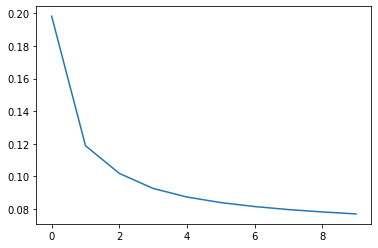

In [12]:
# Let's check how training loss looks
plt.plot(losses)

In [13]:
def plot_imgs(original_images, result_images):
    # Plot the first ten input images and ten reconstructed images
    # Input images on top, reconstructed on bottom
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

    for images, row in zip([original_images, result_images], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape(-1, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)        

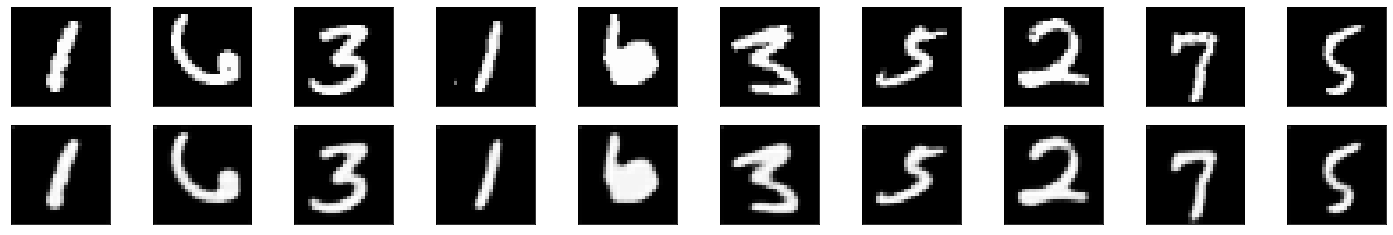

In [14]:
plot_imgs(original_images, result_images)

# Deeper autoencoder

Let's try to implement autoencoder which uses more hidden layers

In [20]:
deep_encoder_weights = {
    'encoder_input_conv': tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    'encoder_input_bias': tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    'encoder_hidden_conv': tf.Variable(
        tf.truncated_normal([5, 5, 4, 8], stddev=0.1)),
    'encoder_hidden_bias': tf.Variable(
        tf.truncated_normal([8], stddev=0.1)),
    'decoder_hidden_deconv': tf.Variable(
        tf.truncated_normal([5, 5, 4, 8], stddev=0.1)),
    'decoder_hidden_bias': tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    'decoder_output_deconv': tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    'deconv_output_bias': tf.Variable(
        tf.truncated_normal([1], stddev=0.1))
}

In [25]:
ae_input = tf.placeholder(tf.float32, [batch_size, 784])

data = tf.reshape(ae_input, [-1, 28, 28, 1])

encoder_input_out = tf.nn.leaky_relu(
    tf.nn.conv2d(data,
                 deep_encoder_weights['encoder_input_conv'],
                 strides=[1, 2, 2, 1],
                 padding='SAME') + deep_encoder_weights['encoder_input_bias'])
    
encoder_hidden_out = tf.nn.leaky_relu(
    tf.nn.conv2d(encoder_input_out,
                deep_encoder_weights['encoder_hidden_conv'],
                strides=[1, 2, 2, 1],
                padding='SAME') + deep_encoder_weights['encoder_hidden_bias'])

decoder_hidden_out = tf.nn.leaky_relu(
    tf.nn.conv2d_transpose(encoder_hidden_out,
                           deep_encoder_weights['decoder_hidden_deconv'],
                           [batch_size, 14, 14, 4], #Shape
                           strides=[1, 2, 2, 1],
                           padding='SAME') + deep_encoder_weights['decoder_hidden_bias'])

decoder_output = tf.nn.sigmoid(
    tf.nn.conv2d_transpose(decoder_hidden_out,
                          deep_encoder_weights['decoder_output_deconv'],
                          input_shape,
                          strides=[1, 2, 2, 1],
                          padding='SAME') + deep_encoder_weights['deconv_output_bias'])

In [26]:
optimizer_adam = tf.train.AdamOptimizer()

deep_cost = tf.reduce_mean(tf.squared_difference(decoder_output, data))

deep_ae_op = optimizer_adam.minimize(deep_cost)

result_images, losses = train(deep_ae_op, deep_cost, decoder_output, n_epochs=10)

Epoch 1/10
	Done: 100.0%, Loss: 0.0416
Epoch 2/10
	Done: 100.0%, Loss: 0.0041
Epoch 3/10
	Done: 100.0%, Loss: 0.0028
Epoch 4/10
	Done: 100.0%, Loss: 0.0024
Epoch 5/10
	Done: 100.0%, Loss: 0.0022
Epoch 6/10
	Done: 100.0%, Loss: 0.0020
Epoch 7/10
	Done: 100.0%, Loss: 0.0019
Epoch 8/10
	Done: 100.0%, Loss: 0.0018
Epoch 9/10
	Done: 100.0%, Loss: 0.0018
Epoch 10/10
	Done: 100.0%, Loss: 0.0017


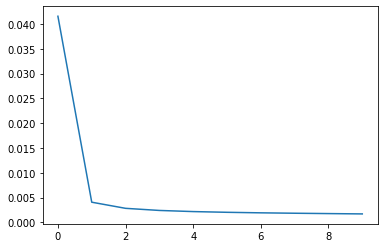

In [27]:
# Let's check how training loss looks
plt.plot(losses)

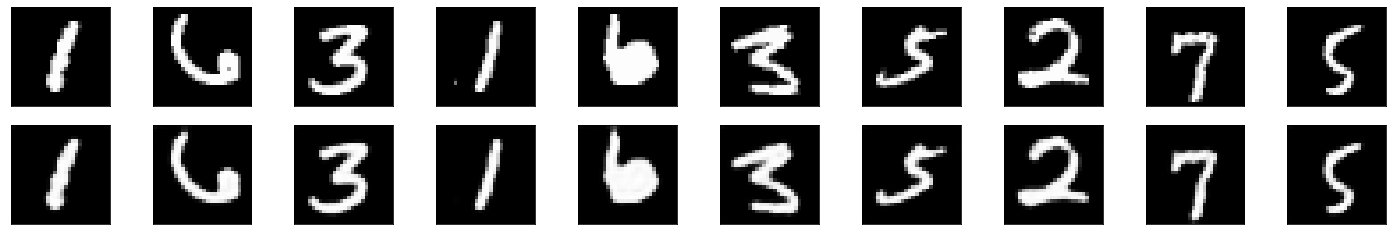

In [28]:
plot_imgs(original_images, result_images)